## 2 - The General Linear Model
### Getting to grips with linear models in Python

This week we will focus on three things:
- How to do basic, psychology-standard analyses in Python using the `pingouin` package
- How to implement a general linear model in Python with `statsmodels`
- and understanding the connection between the two with some examples.

Don't worry if this confusing. It takes many repetitions and practice to get it to stick!

### Part 1 - The `pingouin` package for basic statistics
You will be familiar with basic statistics in psychology at this point, and it is very useful to know how to do them in Python. The `pingouin` package covers most of these, and it works seamlessly with `pandas`. As before we need to import it, so we will call our needed packages here.

In [1]:
# Import what we need
import pandas as pd # dataframes
import seaborn as sns # plots
import pingouin as pg # stats, note the traditional alias

# Set the style for plots
sns.set_style('dark') # a different theme!
sns.set_context('talk')

Lets see how this package allows us to do some basic psychology-style analyses, with some example datasets that we can load from `seaborn`.

#### The **independent** samples t-test
This t-test is often the first analysis we learn. With `pingouin`, it is handled by the `pg.ttest` function. Lets load up the `tips` dataset and do a t-test.

**Test**: Do smokers tip more than non-smokers? To test this we need to give the function just the values for each group, which we get by filtering our data.

In [2]:
# First load the data
tips = sns.load_dataset('tips')
display(tips.head(2))

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3


In [3]:
# First filter the data by smokers and nonsmokers, and select the tip column
smokers = tips.query('smoker == "Yes"')['tip']
nonsmokers = tips.query('smoker == "No"')['tip']

# Pass to the t-test function
pg.ttest(smokers, nonsmokers).round(4)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.0918,192.2634,two-sided,0.9269,"[-0.35, 0.38]",0.0122,0.145,0.051


#### The **paired** samples t-test 
Comparing the means of two variables is achieved with the same function, but telling it that the two variables are paired. Lets compare the mean bill price with the mean tip price - meals should be on average more expensive than their tips!

In [4]:
# Select the columns
bills = tips['total_bill']
tipamount = tips['tip']

# Do the test
pg.ttest(bills, tipamount, paired=True).round(4)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,32.6465,243,two-sided,0.0,"[15.77, 17.8]",2.6352,1.222e+87,1.0


One-sample tests are also easily achieved by stating the target value as the second input. For example, to compare the mean tip amount to $1, we do `pg.ttest(tipamount, 1)`.

#### Correlation
This useful statistic is a special case of the general linear model as we will see, but it is computed easily enough with  `pg.corr`.

Let us correlate the tip amount and total bill amount:

In [5]:
# Correlation
pg.corr(tips['total_bill'], tips['tip'])

,n,r,CI95%,p-val,BF10,power
pearson,244,0.675734,"[0.6, 0.74]",6.692471e-34,4.952e+30,1.0


#### ANOVA
The analysis of variance (more about the difference in means, actually) comes in many forms - one way, two way, mixed, repeated, analysis of covariance, and so on. We need not dwell on these confusing definitions, but it is good to demonstrate how they are handled.

#### One-way ANOVA
Designed for testing mean differences in a continuous outcome under two or more groups, in the `pg.anova` function. Let's examine whether the amount of tips vary over different days - the `tips` dataset has Thursday-Sunday as days. A plot will help us.

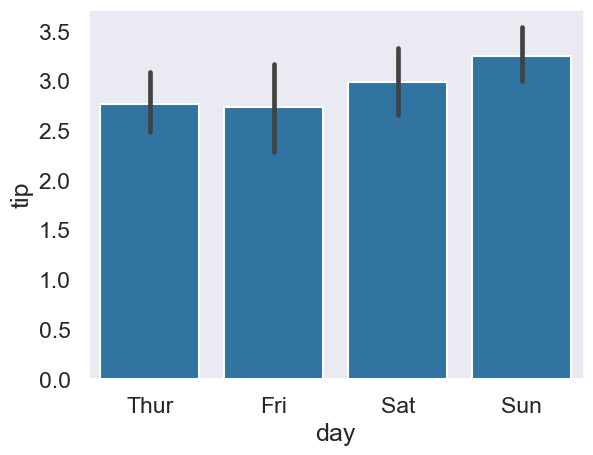

In [6]:
# Plot tips
sns.barplot(data=tips, x='day', y='tip');

In [7]:
# A one-way ANOVA tests for differences amongst those means
# Notice we pass tips to the 'data' argument. 
# Notice 'between' refers to the between subjects measure 
# we can add more variables to 'between'
pg.anova(data=tips, dv='tip', between=['day'])

,Source,ddof1,ddof2,F,p-unc,np2
0,day,3,240,1.672355,0.173589,0.020476


Extending this to a 'two-way' ANOVA is easy - tip differences among days and men and women?

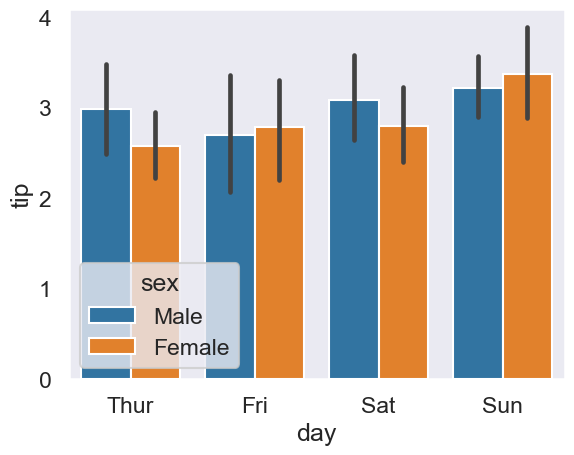

In [8]:
# Plot tips
sns.barplot(data=tips, x='day', y='tip', hue='sex');

In [9]:
# Extend ANOVA
pg.anova(data=tips, between=['day', 'sex'], dv='tip')

,Source,SS,DF,MS,F,p-unc,np2
0,day,7.446900,3.0,2.482300,1.298061,0.275785,0.016233
1,sex,1.594561,1.0,1.594561,0.833839,0.362097,0.003521
2,day * sex,2.785891,3.0,0.928630,0.485606,0.692600,0.006135
3,Residual,451.306151,236.0,1.912314,NaN,NaN,NaN


Further cases can be handled such as:
- Analysis of Covariance, ANCOVA - 'controlling' for a variable before the ANOVA is run, `pg.ancova`.
- Repeated measures ANOVA - analysing fully repeated measures, all within-participants, `pg.rm_anova`.
- Mixed ANOVA - analysing data with one variable measured between, and another within, `pg.mixed_anova`.

The latter two will required your data in **long-form**. `
pingouin` has loads of other options you can try too for many things outside of ANOVA.

### Part 2 - `statsmodels` for general linear models
Now for the main course. This approach will serve us for most of the rest of the module, and serve you well for the future!

`statsmodels` is a package for building statistical models, and gives us full flexibility in building our models. It works in conjunction with `pandas` dataframes, integrating them with a *formula string* interface that lets us specify our model structure in a simple way. 

First, lets import it.

In [10]:
# Import statsmodels formula interface
import statsmodels.formula.api as smf 
# looks a little different due to structure of package

Let's build a model that predicts tip amount from the bill and number of diners. To do this, we use `statsmodels` `ols` function, pass the string that defines the model, and the data, and tell it `.fit()`. A lot of steps, but simple ones:


In [11]:
# Build and fit our model
first_model = smf.ols('tip ~ 1 + total_bill + size', data=tips).fit()

Things to note:
- The names of the included variables are the column names of the dataframe.
- The DV is on the left and separated with `~`, which can be read as 'is predicted/modelled by'.
- The `1` means 'fit an intercept`. We almost always want this.
- We include predictors by literally adding them to the model with a plus.

Once we have fit this model, we can ask it to provide us with a `.summary()`, which gives the readout of information in the regression.

In [12]:
# Show the summary of the fitted model
first_model.summary(slim=True)
# slim=False has more, but less relevant, info

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    tip   R-squared:                       0.468
Model:                            OLS   Adj. R-squared:                  0.463
No. Observations:                 244   F-statistic:                     105.9
Covariance Type:            nonrobust   Prob (F-statistic):           9.67e-34
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6689      0.194      3.455      0.001       0.288       1.050
total_bill     0.0927      0.009     10.172      0.000       0.075       0.111
size           0.1926      0.085      2.258      0.025       0.025       0.361
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The `formula` interface is very flexible and allows you to alter the variables in the dataframe by modifying the formula. For example, if we want to z-score our predictors, we can use the `scale` function directly in the formula, and it will adjust the variables for us:

In [13]:
# Scale predictors
scale_predictors = smf.ols('tip ~ 1 + scale(total_bill) + scale(size)', 
                           data=tips).fit()
scale_predictors.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    tip   R-squared:                       0.468
Model:                            OLS   Adj. R-squared:                  0.463
No. Observations:                 244   F-statistic:                     105.9
Covariance Type:            nonrobust   Prob (F-statistic):           9.67e-34
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             2.9983      0.065     46.210      0.000       2.870       3.126
scale(total_bill)     0.8237      0.081     10.172      0.000       0.664       0.983
scale(size)           0.1828      0.081      2.258      0.025       0.023       0.342
=====================================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Extending to the DV is also simple - this is the 'standardised coefficients' you see in some statistics software:

In [14]:
# Scale predictors
scale_all = smf.ols('scale(tip) ~ 1 + scale(total_bill) + scale(size)',
                    data=tips).fit()
scale_all.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             scale(tip)   R-squared:                       0.468
Model:                            OLS   Adj. R-squared:                  0.463
No. Observations:                 244   F-statistic:                     105.9
Covariance Type:            nonrobust   Prob (F-statistic):           9.67e-34
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -3.851e-16      0.047   -8.2e-15      1.000      -0.093       0.093
scale(total_bill)     0.5965      0.059     10.172      0.000       0.481       0.712
scale(size)           0.1324      0.059      2.258      0.025       0.017       0.248
=====================================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Extra scores and attributes
While the `.summary()` printout has a lot of useful features, there are a few other things to know about. 
- the `.fittedvalues` attribute contains the actual predictions.
- the `.resid` attribute contains the residuals or errors.
- `.summary()` doesn't show us the RMSE, or how wrong our model is on average. We can import a function from `statsmodels` to do that for us, which we do next.

We need to import the `import statsmodels.tools.eval_measures` package, and use its `.rmse` function. We need the predictions and the actual data, which is easy to access!

In [15]:
# Import it with the meausres name
import statsmodels.tools.eval_measures as measures
measures.rmse(first_model.fittedvalues, tips['tip']) 
# notice we put in the predictions, and then the actual values

1.007256127114662

### Part 3 - Wait, its just the general linear model?
Now we've seen how easy it is to fit models, we can demonstrate some equivalences between standard statistics and how they are instances of the general linear model. First, a correlation.

A correlation is a general linear model, when you have **one predictor**, and you **standardise both the predictor and the dependent variable**.

Lets re-correlate tips and total bill:

In [16]:
# Correlate
pg.corr(tips['tip'], tips['total_bill'])

,n,r,CI95%,p-val,BF10,power
pearson,244,0.675734,"[0.6, 0.74]",6.692471e-34,4.952e+30,1.0


Now lets perform a linear model, scaling both the DV and predictor (which is which does not matter):

In [17]:
# Linear model
smf.ols('scale(total_bill) ~ scale(tip)', 
        data=tips).fit().summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      scale(total_bill)   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.454
No. Observations:                 244   F-statistic:                     203.4
Covariance Type:            nonrobust   Prob (F-statistic):           6.69e-34
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   7.286e-16      0.047   1.54e-14      1.000      -0.093       0.093
scale(tip)     0.6757      0.047     14.260      0.000       0.582       0.769
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The intercept is as close to zero as our computer can handle, and the coefficient equals the correlation!

A t-test is also simple, comparing tips between females and males:

In [18]:
# Conduct t-test
pg.ttest(tips.query('sex == "Female"')['tip'], 
         tips.query('sex == "Male"')['tip'],
         correction=False) # uncorrected t-tests are at least the same :) 

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.38786,242,two-sided,0.166456,"[-0.62, 0.11]",0.185494,0.361,0.282179


In [19]:
# As a linear model
ttest_model = smf.ols('tip ~ sex', data=tips).fit()
ttest_model.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    tip   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.004
No. Observations:                 244   F-statistic:                     1.926
Covariance Type:            nonrobust   Prob (F-statistic):              0.166
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         3.0896      0.110     28.032      0.000       2.873       3.307
sex[T.Female]    -0.2562      0.185     -1.388      0.166      -0.620       0.107
=================================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

And we can confirm the mean difference is as the model suggests:

In [20]:
# Confirm mean difference
means = tips.groupby(by=['sex'], observed=False).agg({'tip': 'mean'})
display(means)
display(means.loc['Female'] - means.loc['Male'])

,tip
sex,
Male,3.089618
Female,2.833448


tip   -0.25617
dtype: float64

For a final graphical illustration, let us recode the `sex` variable of tips into a column that has:
- Males are 0
- Females are 1

And plot that against the `fittedvalues`, and overlay the raw data.

In [21]:
# Generate values
female_one_male_zero = tips['sex'].case_when(
    [
        (tips['sex'] == "Female", 1),
        (tips['sex'] == "Male", 0)
    ]
)

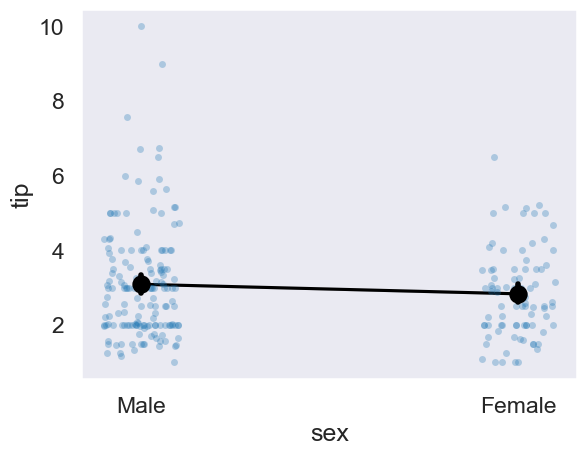

In [22]:
# Raw data
axis = sns.stripplot(data=tips, y='tip', x='sex', alpha=.3)
# Adds the means of each sex
sns.pointplot(data=tips, y='tip', x='sex', 
              linestyle='none', color='black', ax=axis, zorder=3)
# Add the predictions
sns.lineplot(x=female_one_male_zero,
             y=ttest_model.fittedvalues,
             color='black');

Finally, we will consider how a one-way ANOVA works, and demonstrate how a linear model 'sees' an ANOVA.

Lets compare the means of tips given on the different days (Thursday, Friday, Saturday, Sunday). The traditional approach here is the one-way ANOVA, done like so:

In [23]:
# One way ANOVA
pg.anova(data=tips, between=['day'], dv='tip', effsize='n2')

,Source,ddof1,ddof2,F,p-unc,n2
0,day,3,240,1.672355,0.173589,0.020476


Building this model as a GLM is conceptually very simple - we predict tips, from day. Lets fit this model and explore some consequences.

In [24]:
# Fit the ANOVA style model
anova = smf.ols('tip ~ day', data=tips).fit()
anova.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    tip   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.008
No. Observations:                 244   F-statistic:                     1.672
Covariance Type:            nonrobust   Prob (F-statistic):              0.174
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.7715      0.175     15.837      0.000       2.427       3.116
day[T.Fri]    -0.0367      0.361     -0.102      0.919      -0.748       0.675
day[T.Sat]     0.2217      0.229      0.968      0.334      -0.229       0.673
day[T.Sun]     0.4837      0.236      2.051      0.041       0.019       0.948
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Note that the $R^2$ is the same, as is the F statistic and the p-value!

The coefficients are interesting here. You can see they state Fri, Sat, and Sun. Where is Thursday? Much like in the t-test example, *Thursday is absorbed into intercept*. 
Each coefficient represents the difference between the intercept and that particular day. When all the coefficient are zero (i.e., not that day) then the model returns the mean of Thursdays tips. Again we will focus on our models capabilities to predict things as we continue, but in these instances it is good to know what the coefficients mean before things get too complex.


### The design matrix
This is a technical aside but can be useful in gaining understanding as we move forward. Behind every model you build in `statsmodels`, there is something called the *design matrix*. The data you provide isn't always the data that the model is fitted to, but it is transformed in a way that OLS can use. For example, you can't do statistics on strings ('Thursday', 'Female', etc) - there is a transform that happens to make a numeric version of it. This is sometimes referred to as 'dummy coding', where a categorical variable will be spread into as many columns as there are levels of the variable, with a '1' representing a particular level and zero elsewhere. 

An example will help. Consider the following dataframe that has some simple categorical-style data.

In [25]:
# Create a small categorical dataset
df = pd.DataFrame({'categories': ['Wales', 'Wales', 'England', 
                                  'Scotland', 'Ireland']})
display(df)

,categories
0,Wales
1,Wales
2,England
3,Scotland
4,Ireland


We could imagine this is a predictor in a regression. In its current form, it won't work. However, we can import something called `patsy`, a package that does the translating of datasets for us for our models. It has a function called the `dmatrix` which will turn this data into what a model will see, that is, the design matrix. It works in much the same way as `smf.ols` does. Lets import it and demonstrate:

In [26]:
# Import just the design matrix
from patsy import dmatrix
dmatrix('~ categories', data=df, return_type='dataframe') 
# notice there's no DV but the formula is the same!

,Intercept,categories[T.Ireland],categories[T.Scotland],categories[T.Wales]
0,1.0,0.0,0.0,1.0
1,1.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0
3,1.0,0.0,1.0,0.0
4,1.0,1.0,0.0,0.0


You can see that it has chosen England to become the intercept (this is chosen alphabetically), and each column has a '1' where the title of that column exists in the original data. This representation is what Python uses to build our models. This is not essential to know but it will deepen your understanding.